Project: Traffic Sign Recognition Classifier
=========

In [168]:
from pathlib import Path
import pickle
from itertools import zip_longest
from math import ceil, sqrt
from typing import Tuple
import shutil

from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.layers import Flatten
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

tf.compat.v1.disable_v2_behavior() 
print(f"Using TF {tf.__version__} but with TF 1 behavior.")

DATA_BASE_PATH = Path("~/data/udacity").expanduser()
MODEL_DIR = Path("./models")

Using TF 2.1.0 but with TF 1 behavior.


---
## Step 0: Load The Data

In [199]:
training_file = DATA_BASE_PATH / "train.p"
validation_file = DATA_BASE_PATH / "valid.p"
testing_file = DATA_BASE_PATH / "test.p"

with training_file.open(mode='rb') as f:
    train = pickle.load(f)
with validation_file.open(mode='rb') as f:
    valid = pickle.load(f)
with testing_file.open(mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `data/signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
n_train = X_train.shape[0]
n_validation = X_valid.shape[0]
n_test = X_test.shape[0]

# Shape of an traffic sign image:
image_shape = X_train.shape[1:]

# Number of unique classes/labels in the dataset:
n_classes = len(np.unique(y_valid))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the dataset

In [4]:
X_train.shape

(34799, 32, 32, 3)

In [5]:
def plot_many(n_to_plot, idxes):
    ncols = 4
    nrows = ceil(n_to_plot / ncols)

    _, axes = plt.subplots(nrows=nrows, ncols=ncols, 
                           figsize=(14, nrows * 3), sharex=True, sharey=True)
    for idx, ax in zip_longest(idxes, axes.ravel()):
        if idx:
            ax.imshow(X_train[idx])
        else:
            ax.axis("off")

    plt.tight_layout()
    plt.show()

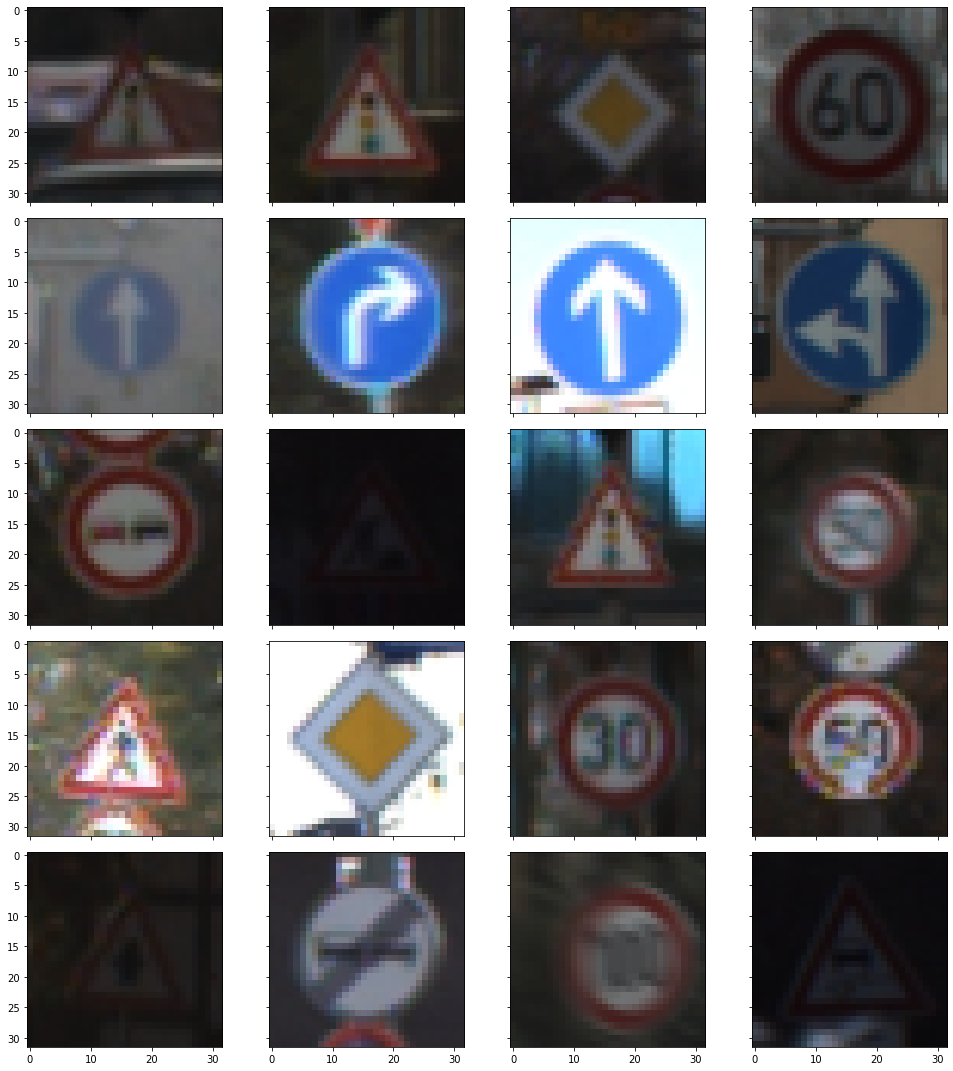

In [6]:
n_random = 20
random_idxes = np.random.choice(range(n_train), size=n_random, replace=False)

plot_many(n_random, random_idxes)

Let's take a look at the distribution of signs and inspect some that are a bit obscure (and thus potentially harder to learn): 

In [7]:
def plot_single_sign(sign):
    n_random = 12
    idxes = np.argwhere(y_train == sign).flatten()
    random_idxes = np.random.choice(idxes, size=n_random, replace=False)

    plot_many(n_random, random_idxes)
    

sign_id, sign_cnts = np.unique(y_train, return_counts=True)
sign_df = (
    pd.DataFrame({"ClassId": sign_id, "count": sign_cnts})
    .set_index("ClassId")
    .merge(
        pd.read_csv("data/signnames.csv")
        .set_index("ClassId"),
        left_index=True, 
        right_index=True
    )
    .assign(SignNameId=lambda df: df["SignName"] + " (" + df.index.astype(str) + ")")
    .sort_values(by="count", ascending=False)
)
sign_df.head()

,count,SignName,SignNameId
ClassId,,,
2,2010,Speed limit (50km/h),Speed limit (50km/h) (2)
1,1980,Speed limit (30km/h),Speed limit (30km/h) (1)
13,1920,Yield,Yield (13)
12,1890,Priority road,Priority road (12)
38,1860,Keep right,Keep right (38)


Text(0.5, 1.0, 'Number of occurances per sign')

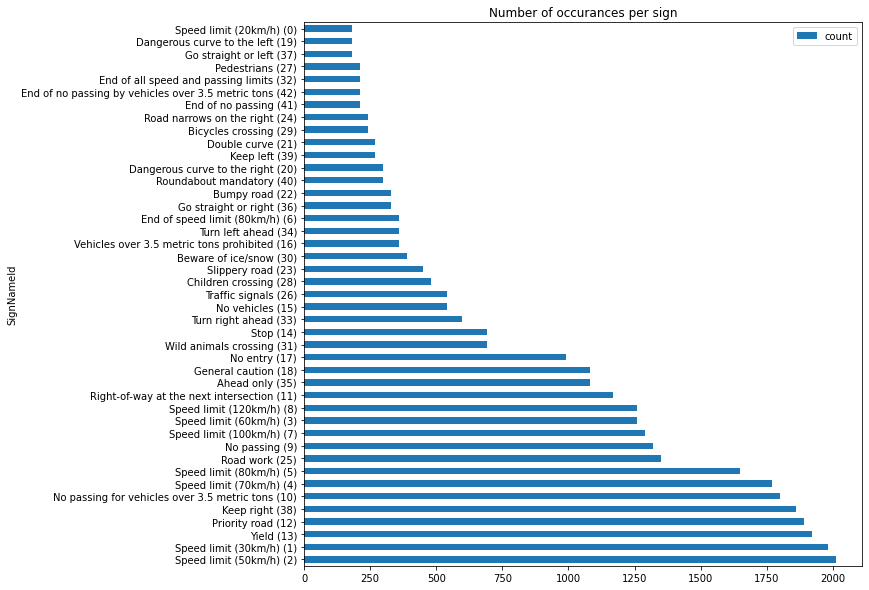

In [8]:
sign_df.plot(kind="barh", x="SignNameId", figsize=(10, 10))
plt.title("Number of occurances per sign")

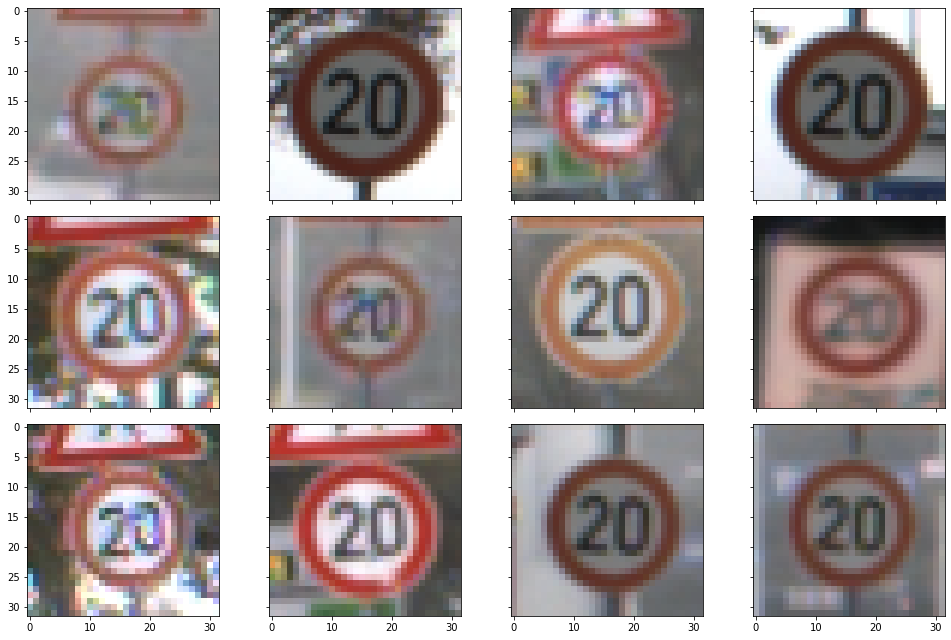

In [9]:
plot_single_sign(0)

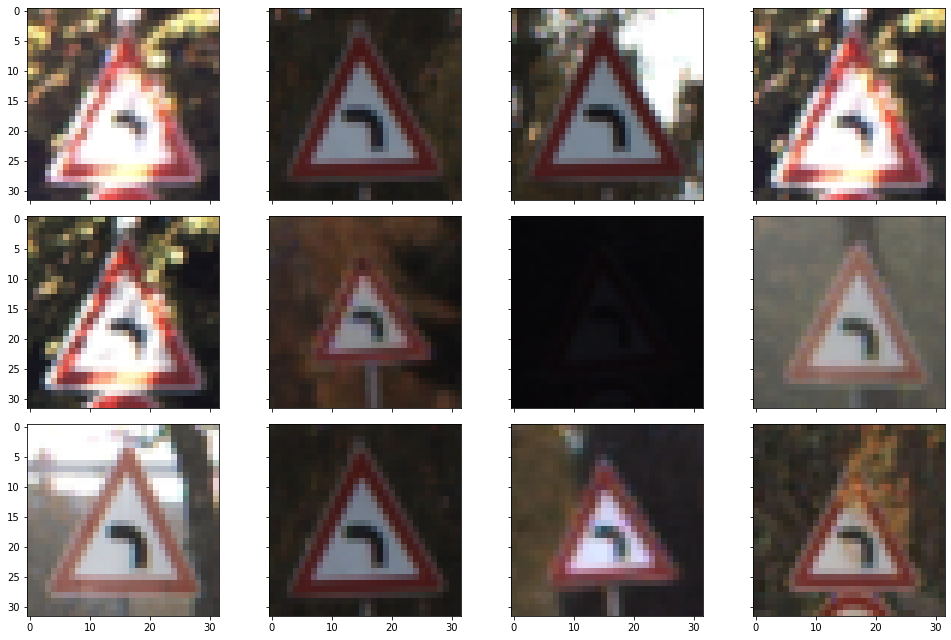

In [10]:
plot_single_sign(19)

Some are really dark, some are overexposed. Might be challenging to deal with these cases.

----

## Step 2: Design and Test a Model Architecture

References:
- example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf).
- dataset description: [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).
- [Reference LeNet implementation from Udacity classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/168c60f1-cc92-450a-a91b-e427c326e6a7/modules/6b6c37bc-13a5-47c7-88ed-eb1fce9789a0/lessons/0fb1d383-484e-4c49-a0e4-03922c1416d6/concepts/8a6df4e1-252b-4cf5-b7b4-aac383e563c5)

Goal: $\geq .93$ accuracy on valid set.


### Step 2a: Pre-process the Data Set (normalization, grayscale, etc.)

In [200]:
X_train_raw = X_train
X_valid_raw = X_valid
X_test_raw = X_test

In [202]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

def preprocess(train_mean: float, X: np.ndarray) -> np.ndarray:
    """Preprocess data. For now, this simply normalizes the data.
    """
    return (X - train_mean) / 128

train_mean = X_train.mean()
X_train = preprocess(train_mean, X_train_raw)
X_valid = preprocess(train_mean, X_valid_raw)
X_test = preprocess(train_mean, X_test_raw)

### Step 2b: Model Architecture
This model is based on the LeNet implementation as covered in class, with a few changes:
- All RGB channels instead of grayscale.
- Added dropout to the two fully connected layers at the end.
- Changed initialization for layers wtih ReLU activation function to He, with mean 0 and variance $\frac{2}{fan\_in}$ where $fan\_in$ is the number of input units.
- 10 hardcoded output classes to `n_classes`

In [203]:
def LeNet(x, dropout_prob):    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.random.truncated_normal(shape=(5, 5, 3, 6), mean=0, 
                                                     stddev=sqrt(2 / (32 * 32 * 3))))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.random.truncated_normal(shape=(5, 5, 6, 16), mean=0, 
                                                     stddev=sqrt(2 / (14 * 14 * 6))))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = Flatten()(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.random.truncated_normal(shape=(400, 120), mean=0, 
                                                   stddev=sqrt(2 / 400)))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.random.truncated_normal(shape=(120, 84), mean=0, 
                                                    stddev=sqrt(2 / 120)))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    fc2_dropout = tf.nn.dropout(fc2, rate=dropout_prob)
    
    # Activation.
    fc2    = tf.nn.relu(fc2_dropout)

    # Layer 5: Fully Connected. Input = 84. Output = n_classes.
    fc3_W  = tf.Variable(tf.random.truncated_normal(shape=(84, n_classes), mean=0, stddev=
                                                    sqrt(2 / 84)))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    # Dropout on the final fully connected layer:
    logits_dropout = tf.nn.dropout(logits, rate=dropout_prob)
    
    return logits_dropout

In [204]:
def LeNet(x, dropout_prob):    
    sigma = .1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.random.truncated_normal(shape=(5, 5, 3, 6), mean=0, 
                                                     stddev=sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.random.truncated_normal(shape=(5, 5, 6, 16), mean=0, 
                                                     stddev=sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = Flatten()(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.random.truncated_normal(shape=(400, 120), mean=0, 
                                                   stddev=sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.random.truncated_normal(shape=(120, 84), mean=0, 
                                                    stddev=sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    fc2_dropout = tf.nn.dropout(fc2, rate=dropout_prob)
    
    # Activation.
    fc2    = tf.nn.relu(fc2_dropout)

    # Layer 5: Fully Connected. Input = 84. Output = n_classes.
    fc3_W  = tf.Variable(tf.random.truncated_normal(shape=(84, n_classes), mean=0, stddev=sigma))
                         
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    # Dropout on the final fully connected layer:
    logits_dropout = tf.nn.dropout(logits, rate=dropout_prob)
    
    return logits_dropout

### Step 2c: Train, Validate and Test the Model
Again, most of the code here is based on the LeNet code covered in the lab in class.

Main changes:
- Dropout placeholder (enabled for training, disabled at test time)
- Evaluate function also outputs loss
- Running evaluate on both train and valid
- Collecting metrics per epoch for plots at the end (could have also used TensorBoard here, but it trains quickly enough and this is quite convenient).
- Saving checkpoint everytime we get a result with $\geq .93$ valid accuracy

In [208]:
x = tf.compat.v1.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.compat.v1.placeholder(tf.int32, (None))
dropout_prob = tf.compat.v1.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, n_classes)

learning_rate = 0.0003
dropout_prob_value = .4

logits = LeNet(x, dropout_prob=dropout_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=tf.stop_gradient(one_hot_y), logits=logits)
loss_operation = tf.reduce_mean(input_tensor=cross_entropy)
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=rate)
training_operation = optimizer.minimize(loss_operation)

EPOCHS = 20
BATCH_SIZE = 128

In [209]:
correct_prediction = tf.equal(tf.argmax(input=logits, axis=1), tf.argmax(input=one_hot_y, axis=1))
accuracy_operation = tf.reduce_mean(input_tensor=tf.cast(correct_prediction, tf.float32))
saver = tf.compat.v1.train.Saver()

def evaluate(X_data, y_data) -> Tuple[float, float]:
    """Evalute model on entire input dataset, returns loss and accuracy."""
    num_examples = len(X_data)
    total_loss = 0
    total_accuracy = 0
    sess = tf.compat.v1.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset + BATCH_SIZE], y_data[offset:offset + BATCH_SIZE]
        loss, accuracy = sess.run([loss_operation, accuracy_operation], 
                             feed_dict={x: batch_x, y: batch_y, 
                                        dropout_prob: 0})
        total_loss += (loss * len(batch_x))
        total_accuracy += (accuracy * len(batch_x))
    return total_loss / num_examples, total_accuracy / num_examples

In [210]:
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
highest_valid_acc_so_far = 0

if MODEL_DIR.exists():
    shutil.rmtree(MODEL_DIR)

    
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    num_examples = len(X_train)
    
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, 
                                                    dropout_prob: dropout_prob_value})
            
        train_loss, train_accuracy = evaluate(X_train, y_train)
        valid_loss, valid_accuracy = evaluate(X_valid, y_valid)
        train_accs.append(train_accuracy)
        valid_accs.append(valid_accuracy)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
        print(f"EPOCH {(i+1)} | train loss: {train_loss:5.3f} | valid loss: {valid_loss:5.3f} | "
              f"train acc: {train_accuracy:5.3f} | valid acc: {valid_accuracy:5.3f}")
    
        if valid_accuracy >= .93 and valid_accuracy > highest_valid_acc_so_far: 
            highest_valid_acc_so_far = valid_accuracy
            ckpt_name = f"epoch-{i + 1:02d}-validacc-{valid_accuracy:5.3f}"
            print(f"Valid acc target reached and better than previous (if any), saving as {ckpt_name}!")
            saver.save(sess, str(MODEL_DIR / ckpt_name))

EPOCH 1 | train loss: 1.408 | valid loss: 1.597 | train acc: 0.731 | valid acc: 0.668
EPOCH 2 | train loss: 0.614 | valid loss: 0.806 | train acc: 0.883 | valid acc: 0.815
EPOCH 3 | train loss: 0.382 | valid loss: 0.591 | train acc: 0.925 | valid acc: 0.855
EPOCH 4 | train loss: 0.268 | valid loss: 0.471 | train acc: 0.955 | valid acc: 0.890
EPOCH 5 | train loss: 0.197 | valid loss: 0.428 | train acc: 0.965 | valid acc: 0.894
EPOCH 6 | train loss: 0.132 | valid loss: 0.340 | train acc: 0.975 | valid acc: 0.912
EPOCH 7 | train loss: 0.119 | valid loss: 0.351 | train acc: 0.974 | valid acc: 0.905
EPOCH 8 | train loss: 0.089 | valid loss: 0.301 | train acc: 0.984 | valid acc: 0.920
EPOCH 9 | train loss: 0.090 | valid loss: 0.333 | train acc: 0.982 | valid acc: 0.910
EPOCH 10 | train loss: 0.062 | valid loss: 0.260 | train acc: 0.990 | valid acc: 0.930
Valid acc target reached and better than previous (if any), saving as epoch-10-validacc-0.930!
EPOCH 11 | train loss: 0.072 | valid loss: 0

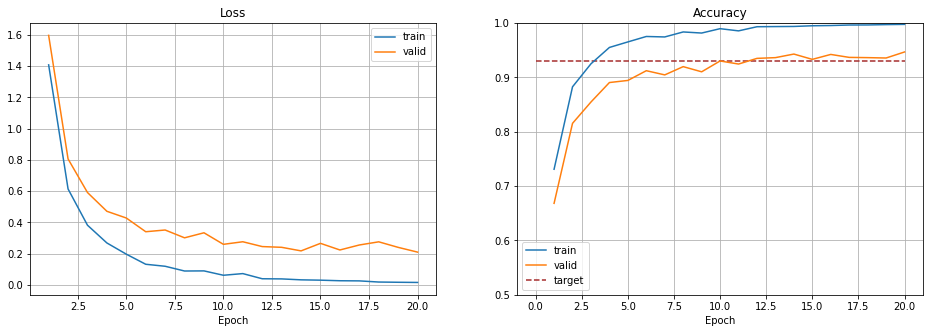

In [211]:
epoch_rng = list(range(1, EPOCHS+1))

_, (l, r) = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
l.plot(epoch_rng, train_losses, label="train")
l.plot(epoch_rng, valid_losses, label="valid")
l.legend()
l.grid()
l.set_xlabel("Epoch")
l.set_title("Loss")

r.plot(epoch_rng, train_accs, label="train")
r.plot(epoch_rng, valid_accs, label="valid")
r.hlines(.93, xmin=0, xmax=EPOCHS, linestyle="--", label="target", color="brown")
r.legend()
r.grid()
r.set_xlabel("Epoch")
r.set_title("Accuracy")
r.set_ylim(0.5, 1)

plt.show()

There is still quite a bit of overfitting here, which could be improved by introducing augmentations: subtle rotations, brightness, contrast, subtle warp transforms, crop+zooms (n.b.: no flips as that will change the meaning of some signs, e.g. sharp left / right turn). This is much easier with a high level framework, so I will leave that for future work (with e.g. Keras).

In [217]:
with tf.compat.v1.Session() as sess:
    saver.restore(sess, str(MODEL_DIR / "epoch-20-validacc-0.947"))
    
    test_loss, test_accuracy = evaluate(X_test, y_test)
    print(f"test loss: {test_loss:5.3f} | test acc: {test_accuracy:5.3f}")

INFO:tensorflow:Restoring parameters from models/epoch-20-validacc-0.947
test loss: 0.334 | test acc: 0.932


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
WEB_IMG_PATH = Path("./web-images")

In [ ]:
!wget https://www.autoeurope.com/default/assets/Image/german-road-signs-traffic.png
!wget https://www.autoeurope.com/default/assets/Image/no-overtaking-sign.png
!wget https://www.autoeurope.com/default/assets/Image/germany-road-sign-snow-chains.png

In [218]:
from PIL import Image

In [ ]:
Image.from

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Predict the Sign Type for Each Image

In [3]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

### Analyze Performance

In [4]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [3]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")